In [1]:
%load_ext autoreload
%autoreload 2

In [53]:
from datetime import datetime

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import torch
import xarray
from dataset.dataset import SingleImageDataset
from dataset.station_dataset import GroundstationDataset
from dataset.normalization import MinMax
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import WandbLogger
from models.ConvResNet_Jiang import ConvResNet
from models.LightningModule import LitEstimator, LitEstimatorPoint
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from types import SimpleNamespace

In [30]:
## Set Up Model

ckpt_fn = "/scratch/snx3000/kschuurm/irradiance_estimation/SIS_point_estimation/qj5zomfa/checkpoints/epoch=4-step=14520.ckpt"

config = {
    "batch_size": 512,
    "patch_size": {'x':15, 
                   'y':15,
                   'stride_x':1,
                   'stride_y':1,
                  },
    "input_overlap": None,
    "x_vars": [
        "channel_1",
        "channel_2",
        "channel_3",
        "channel_4",
        "channel_5",
        "channel_6",
        "channel_7",
        "channel_8",
        "channel_9",
        "channel_10",
        "channel_11",
    ],
    "y_vars": ["SIS"],
    "x_features": ["dayofyear", "lat", "lon", "SZA", "AZI", "DEM"],
    "transform": MinMax(),
    "target_transform": MinMax(),
}
config = SimpleNamespace(**config)

# estimator = LitEstimator()
trainer = Trainer(
    # profiler="simple",
    # num_sanity_val_steps=2,
    accelerator="gpu",
    devices=-1,
    precision="16",
)

model = ConvResNet(num_attr=6, input_channels=11)

estimator = LitEstimatorPoint.load_from_checkpoint(
    ckpt_fn, learning_rate=0.001, model=model, config=config,
)  

/scratch/snx3000/kschuurm/lightning/lib/python3.9/site-packages/lightning/fabric/connector.py:565: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/scratch/snx3000/kschuurm/lightning/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [24]:
seviri = xarray.open_zarr(
                "/scratch/snx3000/acarpent/EumetsatData/SEVIRI_WGS_2016-2022_RSS.zarr"
            ).rename_dims({"x": "lon", "y": "lat"}).rename_vars(
                {
                    "VIS006": "channel_1",
                    "VIS008": "channel_2",
                    "IR_016": "channel_3",
                    "IR_039": "channel_4",
                    "WV_062": "channel_5",
                    "WV_073": "channel_6",
                    "IR_087": "channel_7",
                    "IR_097": "channel_8",
                    "IR_108": "channel_9",
                    "IR_120": "channel_10",
                    "IR_134": "channel_11",
                    "x": "lon",
                    "y": "lat",
                }
            ).drop_duplicates(dim="time")
dem = xarray.open_zarr("/scratch/snx3000/kschuurm/ZARR/DEM.zarr").fillna(0)
solarpos = xarray.open_zarr("/scratch/snx3000/kschuurm/ZARR/SOLARPOS.zarr"
        ).drop_duplicates(dim="time") 
seviri = xarray.merge([seviri, dem, solarpos], join="exact")
sarah = xarray.open_zarr("/scratch/snx3000/kschuurm/ZARR/SARAH3.zarr")

dt = datetime(2015, 5, 10, 12, 1)
seviri_slice = seviri.isel(time=10000)#, method="nearest")
sarah_slice = sarah.sel(time=seviri_slice.time).load()

config = dict(vars(config))
dataset = SingleImageDataset(
    hrseviri=seviri_slice,
    sarah=sarah_slice,
    y_vars=config["y_vars"],
    x_vars=config["x_vars"],
    x_features=config["x_features"],
    patch_size=config["patch_size"],
    transform=config["transform"],
    target_transform=config["target_transform"],
)


In [25]:
X,x,y = dataset[0]
print(X.shape, x.shape, y)

torch.Size([11, 15, 15]) torch.Size([6]) tensor([0.4482], dtype=torch.float16)


<xarray.Dataset>
Dimensions:    ()
Coordinates:
    lat        float64 29.33
    lon        float64 -2.426
    time       datetime64[ns] 2016-05-12T08:00:00
Data variables:
    dayofyear  float64 133.0
    SZA        float64 0.9897
    AZI        float64 1.509
    DEM        float64 549.0
<xarray.Dataset>
Dimensions:  ()
Coordinates:
    time     datetime64[ns] 2016-05-12T08:00:00
    lat      float64 29.33
    lon      float64 -2.426
Data variables:
    SIS      float64 503.9


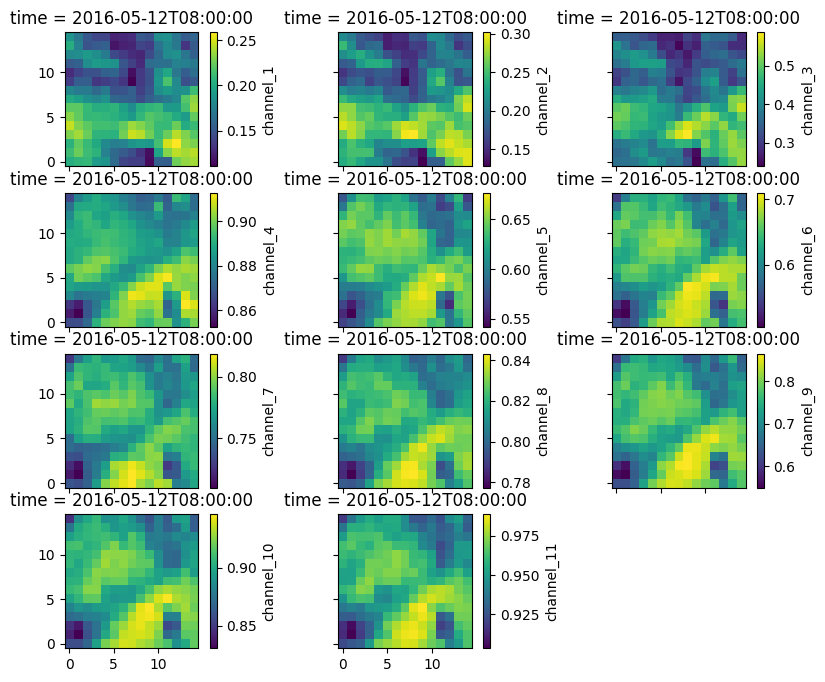

In [26]:
X, x, y = dataset.get_patch_xarray(100, transform_back=True)
print(x)
print(y)

fig, axes = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(10, 8))
axs = axes.flatten()
# X = X.isel(time=0)
for i, key in enumerate(X.keys()):
    # print(X[key])
    X[key].plot.imshow(ax=axs[i], add_labels=True, add_colorbar=True)
    # axs[i].set_title('')
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")
    axs[i].set_aspect("equal")

axs[-1].set_axis_off()
# fig.tight_layout()

In [27]:
dataloader = DataLoader(dataset, batch_size=10000, num_workers=1)
# dataloaderold = DataLoader(dataset_old, batch_size=1000, num_workers=6)

In [31]:
# predictions, x_features
predictions = trainer.predict(estimator, dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [57]:
dataset_CAB = GroundstationDataset(
        station_name='CAB',
        y_vars=config.y_vars,
        x_vars=config.x_vars,
        x_features=config.x_features,
        patch_size=15,
        time_window=12,
        transform=config.transform,
        target_transform=config.target_transform,
    )
dataloader_CAB = DataLoader(dataset_CAB, 1000, shuffle=False)

/scratch/snx3000/kschuurm/lightning/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:201: invalid value encountered in cast


In [70]:
predictions_CAB = trainer.predict(estimator, dataloader_CAB)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [86]:
SIS_pred = torch.vstack([p[0] for p in predictions_CAB])
SIS_station = dataset_CAB.y
error = SIS_pred - SIS_station
error = config.transform.inverse(error.squeeze().cpu(), ['SIS'])
mean = torch.mean(error).item()
std = torch.std(error).item()
print('mean error: ', mean, 'std error: ', std)

# plt.hist(error)

mean error:  333.4072265625 std error:  365.288818359375


In [34]:
def predictions_to_image(predictions, input_image, config, patch_size): 

    y_hat = torch.vstack([x[0] for x in predictions]).squeeze()
    lat = torch.hstack([x[1][:, 1] for x in predictions])
    lon = torch.hstack([x[1][:, 2] for x in predictions])
    
    img_dim = (len(input_image.lat), len(input_image.lon))
    
    y_hat = image_1d_to_2d(y_hat, img_dim, patch_size)
    lat = image_1d_to_2d(lat, img_dim, patch_size)
    lon = image_1d_to_2d(lon, img_dim, patch_size)
    
    
    y_hat = config.target_transform.inverse(y_hat, ["SIS"])
    lat = config.transform.inverse(lat, ["lat"])
    lon = config.transform.inverse(lon, ["lon"])
    
    output_image = xarray.DataArray(
        data=y_hat,
        # dims=('x','y'),
        coords={"lat": lat[:, 0], "lon": lon[0, :]},
        attrs=input_image.SIS.attrs,
    )

    output_image.lat.attrs = input_image.lat.attrs
    output_image.lon.attrs = input_image.lon.attrs
    return output_image
    
def image_1d_to_2d(arr, dim, patch_size):
    return arr.reshape(
        dim[0] - patch_size['y'] + 1,
        dim[1] - patch_size['x'] + 1,
    )

In [37]:
output_image = predictions_to_image(predictions, sarah, config, config.patch_size)

Text(0.5, 1.0, 'DL estimator')

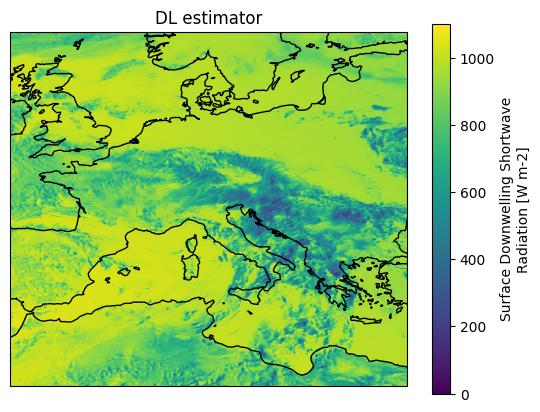

In [39]:
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.coastlines()
output_image.plot.imshow(vmin=0, vmax=1100, ax=ax)
plt.title("DL estimator")
# plt.text(0.5, 0.05, str(input_image.time))

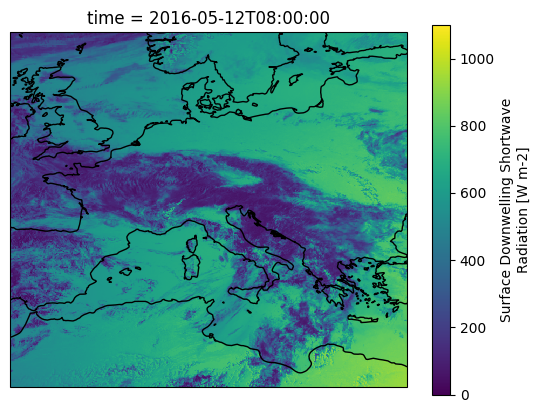

In [41]:
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.coastlines()
sarah_slice.SIS.plot.imshow(vmin=0, vmax=1100, ax=ax)
# plt.title("SARAH-3")

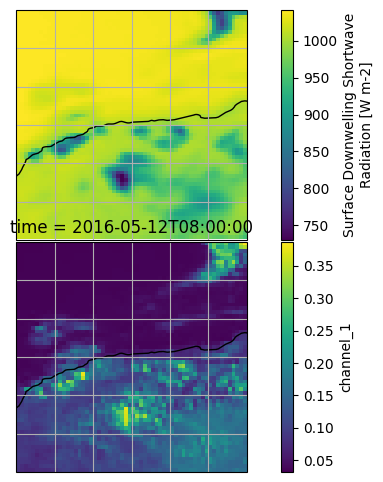

In [45]:
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(
    2,
    1,
    figsize=(9, 6),
    sharex=True,
    sharey=True,
    subplot_kw={"projection": proj, "aspect": 2},
    gridspec_kw={"wspace": 0.2, "hspace": 0.007},
)

lat = slice(35, 38)
lon = slice(0, 3)
axes[0].coastlines()
output_image.sel(
    lat=lat,
    lon=lon,
).plot.imshow(ax=axes[0])
axes[1].coastlines()
seviri_slice.channel_1.sel(lat=lat, lon=lon).plot.imshow(ax=axes[1])
axes[0].gridlines()
axes[1].gridlines()

In [50]:
error = (    output_image -sarah_slice.SIS.reindex_like(output_image, method="nearest"))

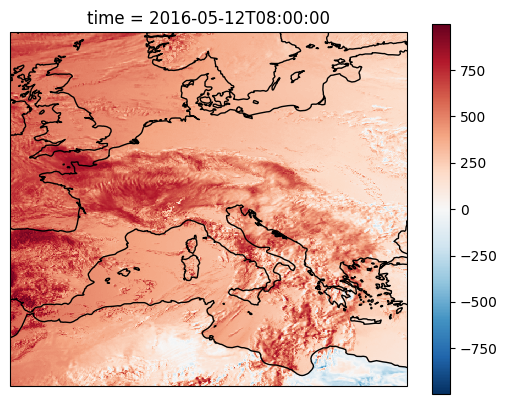

In [51]:
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.coastlines()
error.plot.imshow(ax=ax)